In [1]:
import numpy as np
import pandas as pd
from collections import deque, defaultdict
from datetime import date
from statsmodels.robust.scale import mad
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#数据
from data_cleaning import build_dual_product_panel

panel = build_dual_product_panel(
    config_1={
        "file_path": "dce.parquet",
        "product": "i",
        "method": "volume_stable",
        "price_col": "OpenPx",
        "vol_ratio": 1.2,
        "confirm_days": 2,
    },
    config_2={
        "file_path": "dce.parquet",
        "product": "j",
        "method": "volume_stable",
        "price_col": "OpenPx",
        "vol_ratio": 1.2,
        "confirm_days": 2,
    },
    how="outer"
)

有必要交代一下换月逻辑：
第T天：检测到当月和下一份合约成交量比超过阈值，触发信号
T+1天：平仓换月标的同时根据新标的价格做zscore，若满足平仓逻辑，则平另一腿，若不满足平仓逻辑，按照仓位敞口完成调仓
T+2天：主力合约正式调整为下月合约，这就是为什么数据清洗的时候留了T+2

[√] β = 0.363489 | μ = -0.012114 | σ = 197.897914 | 样本数 = 524


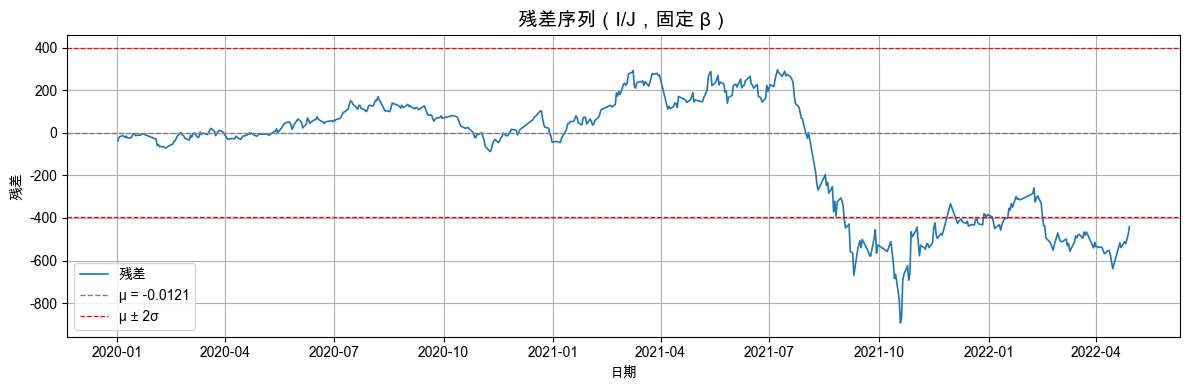

In [3]:
from training_kalman import train_frozen_model_by_products

params = train_frozen_model_by_products(
    panel=panel,
    product_y="I",
    product_x="J",
    beta_cutoff="2022-04-30",
    include_cutoff=True
)

frozen_beta = params["frozen_beta"]
z_mu        = params["z_mu"]
z_std       = params["z_std"]


[2022-05-05 00:00:00] 开仓 多Y空X z=-2.32
[2022-08-05 00:00:00]T+1平旧Y，收益=-44356.49
[2022-08-05 00:00:00] I T+1 立即用新合约开回Y，pos_y=412.6185（按β比），Z=-1.43
[2022-08-23 00:00:00]T+1平旧X，收益=132284.32
[2022-08-23 00:00:00]T+1立即用新合约开回X，pos_x=-149.9822（按beta比），Z=-1.56
[2022-12-06 00:00:00]T+1平旧Y，收益=15885.81
[2022-12-06 00:00:00] I T+1 立即用新合约开回Y，pos_y=412.6185（按β比），Z=-1.25
[2022-12-15 00:00:00]T+1平旧X，收益=-28871.58
[2022-12-15 00:00:00]T+1立即用新合约开回X，pos_x=-149.9822（按beta比），Z=-1.30
[2023-04-06 00:00:00] 平仓 z=-0.29 -> 收益=90528.34 (revert)


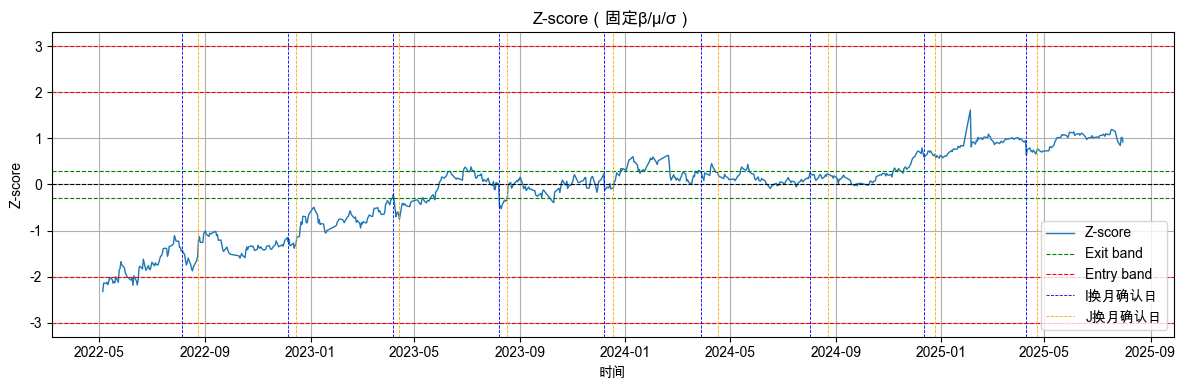

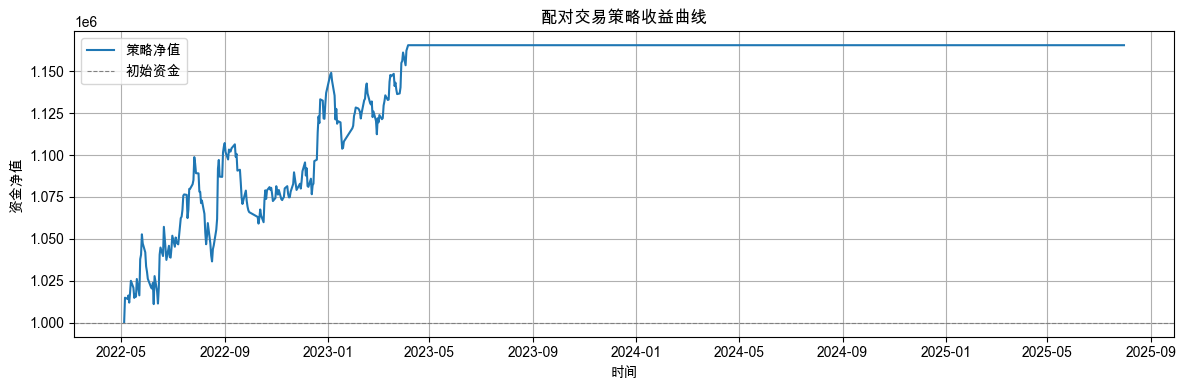

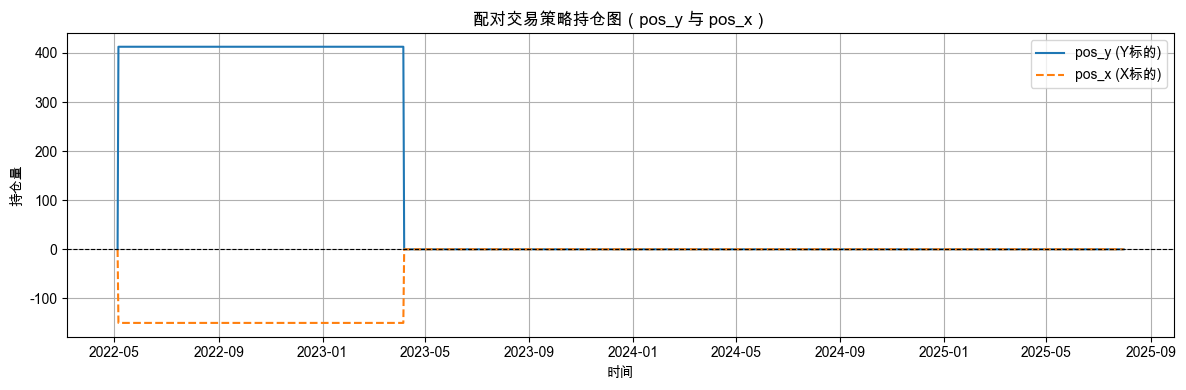

In [4]:
#策略参数
from datetime import timedelta
#开仓阈值
ENTRY_Z_LOW = 2.0
ENTRY_Z_HIGH = 3.0
#平仓阈值
EXIT_BAND = 0.3
STOP_Z = 4.5
POS_PCT = 0.9
INIT_CAP = 1000000
contract_switch_flag_y = False
contract_switch_flag_x = False
switch_day_y = None
switch_day_x = None
BETA_TRAIN_CUTOFF = '2022-4-30'
STD_FLOOR = 1e-6

#准备交易集
trade_df = (
    panel[panel['MDDate'] > pd.to_datetime(BETA_TRAIN_CUTOFF)]
    .dropna(subset=['I_main_eff', 'J_main_eff'])
    .reset_index(drop=True)
)


#初始化交易状态
entry_time = None
entry_z = None
entry_price_y = None
entry_price_x = None
pos_y = 0.0
pos_x = 0.0
cash = INIT_CAP

#日志记录
log_time = []; log_z = []; log_spread = []; log_beta = []
log_nav = [];  log_pos_y = []; log_pos_x = []
roll_dates_y = []; roll_dates_x = []

#平仓区间
def is_exit_zone(z):
    return abs(z) <= EXIT_BAND or abs(z) >= STOP_Z
# 安全 PnL：只有在持仓且有入场价时才计算
def _leg_pnl(curr_price, entry_price, qty):
    if qty != 0 and entry_price is not None:
        return (curr_price - entry_price) * qty
    return 0.0

#for循环模拟撮合 + 收益计算
for i in range(len(trade_df)):
    now = trade_df.loc[i, 'MDDate']
    today = now.date()
    price_y = float(trade_df.loc[i, 'I_main_eff'])
    price_x = float(trade_df.loc[i, 'J_main_eff'])
    
    price_y_old = trade_df.loc[i, 'I_old'] if 'I_old' in trade_df.columns else np.nan
    price_x_old = trade_df.loc[i, 'J_old'] if 'J_old' in trade_df.columns else np.nan
    
    #T和T+1标记（来自面板）
    Iy_T1 = bool(trade_df.loc[i, 'I_is_T1']) if 'I_is_T1' in trade_df.columns else False
    Ix_T1 = bool(trade_df.loc[i, 'J_is_T1']) if 'J_is_T1' in trade_df.columns else False
    if Iy_T1: roll_dates_y.append(now)
    if Ix_T1: roll_dates_x.append(now)

    spread = price_y - frozen_beta * price_x
    zscore = (spread - z_mu) / max(z_std, STD_FLOOR)

    #实时净值记录
    nav = cash
    if pos_y != 0 or pos_x != 0:
        pnl_y = _leg_pnl(price_y, entry_price_y, pos_y)
        pnl_x = _leg_pnl(price_x, entry_price_x, pos_x)
        nav += (pnl_y + pnl_x)
    log_nav.append(nav)

    #日志记录
    log_time.append(now)
    log_z.append(zscore)
    log_spread.append(spread)
    log_beta.append(frozen_beta)
    log_pos_y.append(pos_y)
    log_pos_x.append(pos_x)

    # 只要任一腿进入T+1，就按下列规则处理持仓
    if (Iy_T1 or Ix_T1) and (pos_y != 0 or pos_x != 0):
        #若 z 在平仓带：直接全部退出（触发腿用旧价，另一腿用生效价）
        if is_exit_zone(zscore):
            if pos_x != 0:
                px_close_x = float(price_x_old) if Ix_T1 and pd.notna(price_x_old) else price_x
                pnl_x = _leg_pnl(px_close_x, entry_price_x, pos_x)
                cash += pnl_x
                print(f"[{now}] T+1触发 → 平X（{'旧合约' if Ix_T1 else '生效合约'}），收益={pnl_x:.2f}")
                pos_x = 0.0
            if pos_y != 0:
                px_close_y = float(price_y_old) if Iy_T1 and pd.notna(price_y_old) else price_y
                pnl_y = _leg_pnl(px_close_y, entry_price_y, pos_y)
                cash += pnl_y
                print(f"[{now}] T+1触发 → 平Y（{'旧合约' if Iy_T1 else '生效合约'}），收益={pnl_y:.2f}")
                pos_y = 0.0

            # 清空入场信息
            entry_time = None; entry_z = None
            entry_price_x = None; entry_price_y = None
            continue

        #否则执行平旧仓开新仓，并保持beta对冲敞口一致（不按资金重算）
        #触发腿用旧仓位的价格结算，再按beta比例用“生效价”立刻开回
        if Ix_T1 and pos_x != 0:
            # 平旧X
            if pd.notna(price_x_old):
                pnl_x = _leg_pnl(float(price_x_old), entry_price_x, pos_x)
            else:
                #若没有旧价，退化用eff价（基本不可能发生，防止一下）
                pnl_x = _leg_pnl(price_x, entry_price_x, pos_x)
            cash += pnl_x
            print(f"[{now}]T+1平旧X，收益={pnl_x:.2f}")
            pos_x = 0.0

            #立刻在新合约（也就是eff价格)按beta比例开回，保持仓位敞口
            if pos_y != 0:
                pos_x = -frozen_beta * pos_y
                entry_price_x = price_x
                entry_time = today; entry_z = zscore
                print(f"[{now}]T+1立即用新合约开回X，pos_x={pos_x:.4f}（按beta比），Z={zscore:.2f}")

        if Iy_T1 and pos_y != 0:
            #平旧Y
            if pd.notna(price_y_old):
                pnl_y = _leg_pnl(float(price_y_old), entry_price_y, pos_y)
            else:
                pnl_y = _leg_pnl(price_y, entry_price_y, pos_y)
            cash += pnl_y
            print(f"[{now}]T+1平旧Y，收益={pnl_y:.2f}")
            pos_y = 0.0

            #在eff价格按照beta比例开回Y
            if pos_x != 0:
                pos_y = -pos_x / frozen_beta 
                entry_price_y = price_y
                entry_time = today; entry_z = zscore
                print(f"[{now}] I T+1 立即用新合约开回Y，pos_y={pos_y:.4f}（按β比），Z={zscore:.2f}")

        # 完成当日换月动作
        # 不再继续到“平仓/开仓”通用逻辑，避免重复处理
        continue
    #平仓
    if pos_y != 0 or pos_x != 0:
        revert = abs(zscore) <= EXIT_BAND
        stop   = (zscore <= -STOP_Z and pos_y > 0) or (zscore >= STOP_Z and pos_y < 0)
        if revert or stop:
            pnl = _leg_pnl(price_y, entry_price_y, pos_y) + _leg_pnl(price_x, entry_price_x, pos_x)
            cash += pnl
            print(f"[{now}] 平仓 z={zscore:.2f} -> 收益={pnl:.2f} ({'revert' if revert else 'stop'})")
            entry_time = None; entry_z = None
            pos_y = 0.0; pos_x = 0.0
            entry_price_y = None; entry_price_x = None
            continue

    #正常新开仓
    if (pos_y == 0 and pos_x == 0):
        #任一腿处于T+1，当天禁止从空仓新开
        if Iy_T1 or Ix_T1:
            continue

        if -ENTRY_Z_HIGH <= zscore <= -ENTRY_Z_LOW:
            entry_time = now; entry_z = zscore
            entry_price_y = price_y; entry_price_x = price_x
            lots_y = POS_PCT * cash / (abs(price_y) + frozen_beta * abs(price_x))
            pos_y  =  lots_y
            pos_x  = -frozen_beta * lots_y
            print(f"[{now}] 开仓 多Y空X z={zscore:.2f}")

        elif ENTRY_Z_LOW <= zscore <= ENTRY_Z_HIGH:
            entry_time = now; entry_z = zscore
            entry_price_y = price_y; entry_price_x = price_x
            lots_y = POS_PCT * cash / (abs(price_y) + frozen_beta * abs(price_x))
            pos_y  = -lots_y
            pos_x  =  frozen_beta * lots_y
            print(f"[{now}] 开仓 空Y多X z={zscore:.2f}")

result_df = pd.DataFrame({
    'time': log_time,
    'zscore': log_z,
    'spread': log_spread,
    'beta': log_beta,
    'nav': log_nav,
    'pos_y': log_pos_y,
    'pos_x': log_pos_x
})

#zscore图
plt.figure(figsize=(12, 4))
plt.plot(result_df['time'], result_df['zscore'], label="Z-score", linewidth=1)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.axhline(EXIT_BAND, color="green", linestyle="--", linewidth=0.8, label="Exit band")
plt.axhline(-EXIT_BAND, color="green", linestyle="--", linewidth=0.8)
plt.axhline(ENTRY_Z_LOW, color="red", linestyle="--", linewidth=0.8, label="Entry band")
plt.axhline(ENTRY_Z_HIGH, color="red", linestyle="--", linewidth=0.8)
plt.axhline(-ENTRY_Z_LOW, color="red", linestyle="--", linewidth=0.8)
plt.axhline(-ENTRY_Z_HIGH, color="red", linestyle="--", linewidth=0.8)

for d in roll_dates_y:
    plt.axvline(d, color='blue', linestyle='--', linewidth=0.6, label='I换月确认日' if d == roll_dates_y[0] else "")

for d in roll_dates_x:
    plt.axvline(d, color='orange', linestyle='--', linewidth=0.6, label='J换月确认日' if d == roll_dates_x[0] else "")

plt.title("Z-score（固定β/μ/σ）")
plt.xlabel("时间"); plt.ylabel("Z-score")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#净值图
plt.figure(figsize=(12, 4))
plt.plot(result_df['time'], result_df['nav'], label="策略净值")
plt.axhline(INIT_CAP, color="gray", linestyle="--", linewidth=0.8, label="初始资金")
plt.title("配对交易策略收益曲线"); plt.xlabel("时间"); plt.ylabel("资金净值")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

#持仓图
plt.figure(figsize=(12, 4))
plt.plot(result_df['time'], result_df['pos_y'], label='pos_y (Y标的)', linewidth=1.5)
plt.plot(result_df['time'], result_df['pos_x'], label='pos_x (X标的)', linewidth=1.5, linestyle='--')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.title("配对交易策略持仓图（pos_y 与 pos_x）")
plt.xlabel("时间")
plt.ylabel("持仓量")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import matplotlib.dates as mdates

def plot_position_with_rolls(df, pos_col, time_col, roll_dates, title, color):
    plt.figure(figsize=(12, 4))
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    plt.plot(df[time_col], df[pos_col], label=pos_col, color=color)
    for d in roll_dates:
        plt.axvline(pd.to_datetime(d), color='red', linestyle='--', linewidth=1)
        plt.text(pd.to_datetime(d), plt.ylim()[1]*0.9, '换月', color='red', fontsize=9, ha='left')
    plt.title(title)
    plt.ylabel("持仓量"); plt.xlabel("时间")
    plt.grid(True); plt.tight_layout(); plt.show()

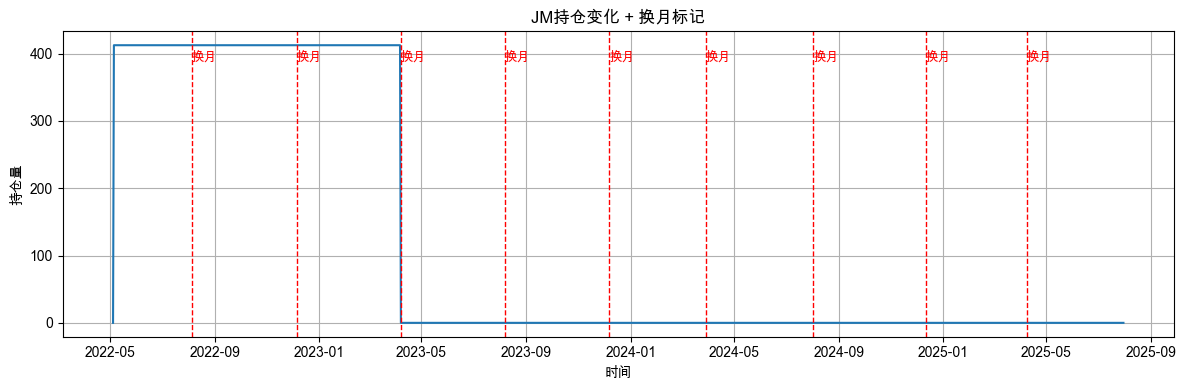

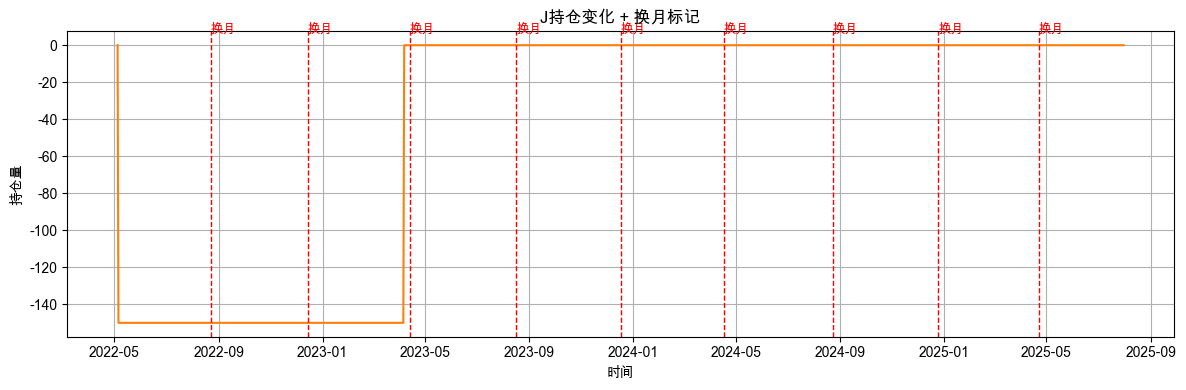

In [11]:
plot_position_with_rolls(result_df, 'pos_y', 'time', roll_dates_y, 'JM持仓变化 + 换月标记', 'tab:blue')
plot_position_with_rolls(result_df, 'pos_x', 'time', roll_dates_x, 'J持仓变化 + 换月标记', 'tab:orange')